## A simple Non-Autonomous Reservoir Computer (RC)

- that maps a given input ($U$) to output ($Y$)

### RC architecture:

<img src="1.RC_NonAuto_IO.png" width="800">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot

import networkx as nx
from numpy.linalg import inv
import os
import random
from tqdm.notebook import tqdm, trange

import RC_SinCosine as RC

# 1. Generate Reservoir Matrix

In [2]:
import random 

Na = 50; ConnProb=0.1; eig_rho = 1.1
G, GNet = RC.ResMat(Na, ConnProb, eig_rho)

N = GNet.shape[0]
Nodes_res=N

print(N, GNet.shape)

50 (50, 50)


### 1.1 Visualizing reservoir matrix

C:\Users\manis\AppData\Local\Temp\ipykernel_31108\2308512550.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1= subplot(1,2,1)


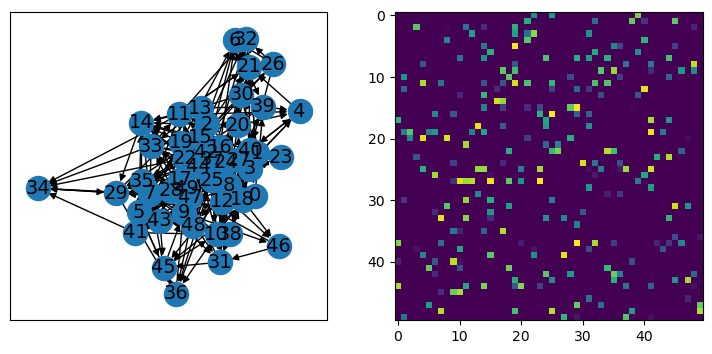

In [3]:
pos=nx.spring_layout(G)
labels = {}
for idx, node in enumerate(G.nodes()):
    labels[node] = idx    

fig_size = plt.rcParams["figure.figsize"]  
fig_size[0] = 9
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size  
plt.title('Input 1 & 2')

ax1= subplot(1,2,1)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, labels, font_size=14)

ax2 = subplot(1,2,2)
im=ax2.imshow(GNet)

plt.show()

# 2. Defining Input receiving nodes in Reservoir

- 25% of reservoir noes to receive input 

In [4]:
InpNodes = int(N*0.25)

Inp1NodeList=random.sample(range(N), InpNodes)
Winp1 = np.zeros(N); 
Winp1[Inp1NodeList] = np.random.random(InpNodes)

print(Inp1NodeList)

[1, 6, 29, 18, 5, 25, 9, 38, 2, 7, 12, 36]


# 3. Task

- RC should learn mapping of input signal $U = sin(\omega_1, \phi_1, t)$ to its complex function $Y = sin^2(\omega_2, \phi_2, t)$

(500,) (500,) (2500,)


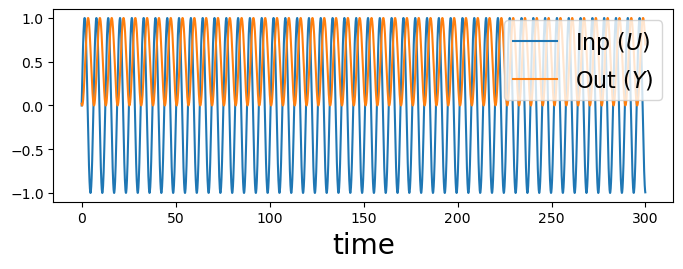

In [5]:
t = np.arange(0, 300, 0.1)

#####Input##################
omega_i1=1; phi_i1=0
U1 = np.sin(omega_i1*t + phi_i1)

#####Output##################
omega_o1=0.5; phi_o1=3
Y1 = np.sin(omega_o1*t + phi_o1)**2
############################

###### Defining some transient to be discarded to avoid artefacts in training
Transients=100; TrPts=500
U1_Train = U1[:TrPts]; Y1_Train = Y1[:TrPts]
U1_Test = U1[TrPts:]; Y1_Test = Y1[TrPts:]
print(U1_Train.shape, Y1_Train.shape, U1_Test.shape)
########################################################

fig_size = plt.rcParams["figure.figsize"]  
fig_size[0] = 8
fig_size[1] = 2.5
plt.plot(t,U1, label=r'Inp ($U$)')
plt.plot(t,Y1, label=r'Out ($Y$)')
plt.legend(loc='upper right', fontsize=16)
plt.xlabel('time', fontsize=20)
plt.show()

# 4. Reservoir Computer

CPU times: total: 0 ns
Wall time: 10.1 ms
(50, 500)


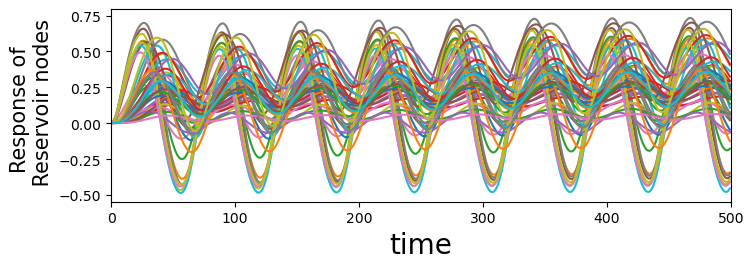

In [6]:
alpha = 0.09999999999
Init = np.random.random(N)*0.01

%time Res = RC.Reservoir(GNet, Init, U1_Train, Winp1, N, alpha)
print(Res.shape)

plt.plot(Res.T)
plt.xlim(0, 500)
# plt.legend(loc='upper right', fontsize=12)
plt.xlabel('time', fontsize=20)
plt.ylabel('Response of \n Reservoir nodes', fontsize=15)
plt.show()

# 4. Training 

- of Output weights $W_{out}$ with Ridge-Regression

In [7]:
beta = 5e-8

### Removing some initial transients before training 
Res_tr = Res[:,Transients:]

W_out = RC.Ridge_Regression(N, Res_tr, beta, Y1_Train[Transients:])
W_out.shape

(50,)

# 5. Testing

In [8]:
%time Res_test = RC.Reservoir(GNet, Init, U1_Test, Winp1, N, alpha)

Y1_Test_pred = np.dot(W_out, Res_test)
error = RC.Errors(Y1_Test_pred[Transients:], Y1_Test[Transients:])

print(Res_test.shape, Y1_Test_pred.shape)

CPU times: total: 234 ms
Wall time: 50 ms
(50, 2500) (2500,)


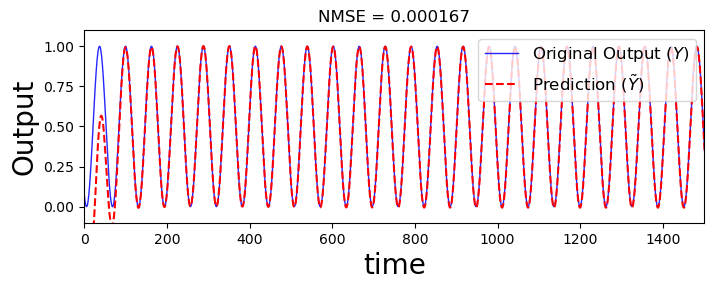

In [12]:
plt.title('NMSE = {:.6f}'.format(error[0]))
plt.plot(Y1_Test, c='blue', alpha=0.85, lw=1, label='Original Output ($Y$)')
plt.plot(Y1_Test_pred, c='red', ls='--', lw=1.5, label=r'Prediction ($\tilde{Y}$)')
plt.ylim(-0.1,1.1)
plt.xlim(0, 1500)
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('time', fontsize=20)
plt.ylabel('Output', fontsize=20)
plt.show()